# Computer Lab: nonnegative matrix factorization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.sparse
import scipy.sparse.linalg
from scipy.optimize import check_grad
import time

In [2]:
def build_matrix_from_faces(folder='orl_faces', minidata=False):
    # load images
    # 400 images of size (112, 92)
    M = []
    if minidata is True:
        nb_subjects = 1
    else:
        nb_subjects = 40
    for subject in range(1, nb_subjects + 1
                        ):
        for image in range(1, 11):
            face = plt.imread(folder + '/s' + str(subject)
                              + '/' + str(image) + '.pgm')
            M.append(face.ravel())

    return np.array(M, dtype=float)

def vectorize(W, H):
    return np.concatenate((W.ravel(), H.ravel()))

def unvectorize_M(W_H, M):
    # number of elements in W_H is (n+p)*k where M is of size n x m
    # W has the nk first elements
    # H has the kp last elements
    n, p = M.shape()
    k = W_H.shape[0] // (n + p)
    W = W_H[:n * k].reshape((n, k))
    H = W_H[n * k:].reshape((k, p))
    return W, H

Download the database at https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html
Uncompress the file.

In [3]:
# Small data to test the algorithm
M = build_matrix_from_faces(folder='orl_faces', minidata=True)
def unvectorize(W_H): return unvectorize_M(W_H, M)
k = 2

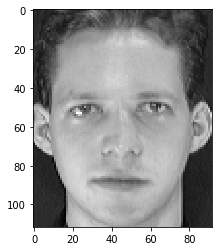

In [4]:
# To see the first face:
plt.imshow(M[0].reshape((112, 92)), cmap='gray'); plt.show()

In [5]:
# Full data
M = build_matrix_from_faces(folder='orl_faces', minidata=False)
def unvectorize(W_H): return unvectorize_M(W_H, M)
k = 38

## Question 2.1

In [6]:
#Number of images 
n=len(M)
print("Number of pictures in the Data base :",n)

#Number of pixels in each picture
p=len(M[0])
print("Number of pixels in each picture :", p)


Number of pictures in the Data base : 400
Number of pixels in each picture : 10304


## Question 3.1

Let's study the objective function in one dimension. The objective function is therefore $$f(x,y) = cste * (x-y)²$$ 
We obtain the following Hessian Matrix (matrix of gradient) :
\begin{vmatrix}
\ 2x² & 4xy-2 \\
\ 4xy-2 & 2y² \\
\end{vmatrix}
Calcul of the determinant : $$ Det = 4x²y² - (4xy-1)² = -8x²y² - (2xy -2)² <0$$
As a consequence, the one dimensionnal function f isn't convex. The objective function is not convex.

## Question 3.2

We call f the objective function. Using the Frobenius norm and the sacalr product associated with this norm :
$$f(W+x,H+y)= \frac{<M-(W+x)(H+y),M-(W+x)(H+y)>}{2np}  $$                         
We obtain: $$f(W+x,H+y)= f(W,H) + \frac{1}{np} *(<M-WH,xH> + <M-WH,Wy>) +o(||(x,y)||) $$ 
We know that $$<A,B>=Tr(A^tB)$$ 
So
$$f(W+x,H+y)= f(W,H) + \frac{1}{np} *(<MH^t-WHH^t,x> + <W^tM-W^tWH,y>) +o(||(x,y)||) $$ 
To conclude: $$ \nabla f(W,H)= \frac{- \begin{vmatrix}
\  MH^t-WHH^t\\
\  W^tM-W^tWH\\
\end{vmatrix}}{np}$$ 

## Question 4.1

In [7]:
W0,S,H0=scipy.sparse.linalg.svds(M,k)
W0=np.maximum(0,W0*np.sqrt(S))
H0=np.maximum(0,(H0.T*np.sqrt(S)).T)

We know that the objective function is not convex, it might have many minima. As a consequence, we want to initialize our data W and H not too far from our objective, which is M = W * H. To do so, we use the singular values of M, and make sure that the matrix W and H we obtained are nonnegative Matrix. Thanks to this initialization, we might get better results and a fast convergence. 
Another possibility of initialization is the use of randomnes to determine W and H, or we can intialize them as null Matrix.

## Question 4.2

The gradient of g is equal to $$ \frac{1}{np} (WHo-M)Ho^t $$. It's own gradient is strictly positive, therefore g is convex.

## Question 4.3

In [8]:
def g_flat(W):
    W = W.reshape((n,k))
    return (np.sum((M-np.dot(W,H0))**2)/(2*n*p)).ravel()
def g_(W):
    return np.sum((M-np.dot(W,H0))**2)/(2*n*p)

def grad_g_flat(W):
    W = W.reshape((n,k))
    return (np.dot(np.dot(W,H0) - M,np.transpose(H0))/(n*p)).ravel()
def grad_g(W):
    return(np.dot(np.dot(W,H0) - M,np.transpose(H0))/(n*p))

check_grad(g_flat, grad_g_flat, W0.ravel())

0.0008857480862424753

## Question 4.4

$$prox_{\gamma t R_{+}}(x)=argmin_{y\in R}(\gamma T_{R+}(y) + \frac{1}{2} ||y-x||^{2})$$
We have $$\gamma T_{R+}(y)= +\infty for y < 0$$ So the minimum argument y is in R+. In moreover, $$\gamma T_{R+}(y) =0 for y\ge 0$$
As a consequence  $$prox_{\gamma t R_{+}}(x)=argmin_{y\in R+}(\gamma T_{R+}(y) + \frac{1}{2} ||y-x||^{2})=argmin_{y\in R}( \frac{1}{2} ||y-x||^{2})$$ 
This is the definition of orthogonal projection in R+.

## Question 4.5

In [9]:
def projected_gradient_method(val_g, grad_g, W0, gamma, N):
    for i in range(N):
        W0=W0-gamma*grad_g(W0)
        W0=W0*(W0>=0)
    return W0


## Question 4.6

In [10]:
k=38
Lo= np.linalg.norm(np.dot(np.transpose(H0), H0), ord='fro')/(n*p)
print("Valeur initiale: ",g_(W0))
print("Valeur finale: ",g_(projected_gradient_method(g_,grad_g,W0,1/Lo,100)))

Valeur initiale:  867.635022960263
Valeur finale:  491.0063314992703


## Question 5.1 

In [11]:
def taylor_search_line(val_g,grad_g,x_prior,gamma_prior):
    a=0.5
    b=2*gamma_prior
    l=0
    gamma=b*(a**l)
    f=lambda g : val_g(x_prior-g*grad_g(x_prior))
    while f(gamma)>val_g(x_prior)-(np.linalg.norm(grad_g(x_prior))**2)*gamma/2:
        l=l+1
        gamma=b*(a**l)
    return gamma

def gradient_method_linear_research(val_g, grad_g, W0, N):
    gamma=1
    for i in range(N):
        gamma=taylor_search_line(val_g,grad_g,W0,gamma)
        W0=W0-gamma*grad_g(W0)
        W0=W0*(W0>=0)
    return W0

## Question 5.2

In [12]:
t1 = time.time()
mini1 = projected_gradient_method(g_, grad_g, W0, 1/Lo, 100)
print("Results without line search")
print("Minimum of the function : ", g_(mini1))
print("Time : ",time.time()-t1)

print("\nResults with line search")
t2 = time.time()
mini2 = gradient_method_linear_research(g_, grad_g, W0, 100)
print("Minimum of the function : ",g_( mini2))
print("Time : ",time.time()-t2)

Results without line search
Minimum of the function :  491.0063314992703
Time :  6.502083778381348

Results with line search
Minimum of the function :  484.37256644668054
Time :  66.88854146003723


We can see that the method with linear research obtains better results, but the time of calcul is 10 times superior than the time of calcul of the method without linear reserch. The improvement in the minimum research is not significant enough compared with the increase of the time of calcul. 

## Question 6.1

In [15]:
#Functions definition
def f_(W, H ):
    return np.sum((M-np.dot(W,H))**2)/(2*n*p)

def grad_f(W, H):
    return [np.dot(np.dot(W,H) - M,np.transpose(H))/(n*p) ,np.dot(np.transpose(W), np.dot(W,H) - M)/(n*p)]

def taylor_search_line2(val_,grad_,w,h,gamma_prior):
    a=0.5
    b=2*gamma_prior
    l=0
    gamma=b*(a**l)
    f=lambda g : val_(w-g*(grad_(w,h)[0]),h-g*grad_(w,h)[1])
    verif=lambda g:val_(w,h)+(np.linalg.norm(grad_(w,h)[0])+np.linalg.norm(grad_(w,h)[1]))*(g/2)
    while f(gamma)>verif(gamma):
        l=l+1
        gamma=b*(a**l)
    return gamma

def gradient_method_linear_research2(val_, grad_, W0,H0, N):
    gamma=1
    for i in range(N):
        gamma=taylor_search_line2(val_,grad_,W0,H0,gamma)
        W0=W0-gamma*grad_(W0,H0)[0]
        H0=H0-gamma*grad_(W0,H0)[1]
        H0=H0*(H0>=0)
        W0=W0*(W0>=0)
    return W0,H0



## Question 6.2

By definition : If $$ Wt=argmin_{W}( \frac{||M-WH_{t-1}||^{2}}{2np})$$
We have $$\frac{||M-W_{t-1}H_{t-1}||^{2}}{2np}<\frac{||M-W_{t}H_{t-1}||^{2}}{2np} $$
Likewise, according to the definition of Ht, we have $$  \frac{||M-W_{t}H_{t-1}||^{2}}{2np}< \frac{||M-W_{t}H_{t}||^{2}}{2np}$$. 
Given that inequality is transitive, we know that at each iteration the objective function is decreasing. 
It is minored by zero, therefore the algorithm converges.

## Question 6.3 

In [23]:

def projected_gradient_W( W0,H0, gamma, N):
    for i in range(N):
        W0=W0-gamma*grad_f(W0,H0)[0]
        W0=W0*(W0>=0)
    return W0
def projected_gradient_H( W0,H0, gamma, N):
    for i in range(N):
        H0=H0-gamma*grad_f(W0,H0)[1]
        H0=H0*(H0>=0)
    return H0

def alternate_min(W,H,N):
    for i in range(N):
        print('Etape ',i)
        Lo = np.linalg.norm(np.dot(H.T, H), ord='fro')/(n*p)
        W = projected_gradient_W(W, H, 1/Lo, 100)
        Lo = np.linalg.norm(np.dot(W.T, W), ord='fro')/(n*p)
        H = projected_gradient_H(W, H, 1/Lo, 100)
    return (W,H)

    

## Question 6.4

In [24]:
print("Initial value in (W0, H0) : ", f_(W0,H0))
t1 = time.time()
W1, H1 = gradient_method_linear_research2(f_, grad_f, W0, H0, 100)
print("\nResults Projected Gradient Method")
print("Minimum of the function : ", f_(W1,H1))
print("Time : ",time.time()-t1)

print("\nResults Alternat Minimum")
t2 = time.time()
W2,H2=alternate_min(W0,H0,100)
print("Minimum of the function : ",f_(W2,H2))
print("Time : ",time.time()-t2)

Initial value in (W0, H0) :  867.635022960263

Results Projected Gradient Method
Minimum of the function :  253.67032085894166
Time :  280.1696746349335

Results Alternat Minimum
Etape  0
Etape  1
Etape  2
Etape  3
Etape  4
Etape  5
Etape  6
Etape  7
Etape  8
Etape  9
Etape  10
Etape  11
Etape  12
Etape  13
Etape  14
Etape  15
Etape  16
Etape  17
Etape  18
Etape  19
Etape  20
Etape  21
Etape  22
Etape  23
Etape  24
Etape  25
Etape  26
Etape  27
Etape  28
Etape  29
Etape  30
Etape  31
Etape  32
Etape  33
Etape  34
Etape  35
Etape  36
Etape  37
Etape  38
Etape  39
Etape  40
Etape  41
Etape  42
Etape  43
Etape  44
Etape  45
Etape  46
Etape  47
Etape  48
Etape  49
Etape  50
Etape  51
Etape  52
Etape  53
Etape  54
Etape  55
Etape  56
Etape  57
Etape  58
Etape  59
Etape  60
Etape  61
Etape  62
Etape  63
Etape  64
Etape  65
Etape  66
Etape  67
Etape  68
Etape  69
Etape  70
Etape  71
Etape  72
Etape  73
Etape  74
Etape  75
Etape  76
Etape  77
Etape  78
Etape  79
Etape  80
Etape  81
Etape  82
E

(Sorry for counting the iterations, but the algorithm was taking forever, I just wanted to be sure that it was still running.)

The Alternat Minimum obtains clearly better results, but the time of calcul is alsor very long. 

## Question 6.5

We could stop the algorithme when the difference of F between to steps is small enough. We could stop when $$||F(x_{k})-F(x_{k+1})||< \epsilon$$